In [1]:
import os, glob
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from seaborn import heatmap, color_palette
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
train_dataset_dir = r'C:\Users\shaki\Desktop\Skin deses dataset\train'
test_dataset_dir = r'C:\Users\shaki\Desktop\Skin deses dataset\test'

width = 224
height = 224

target_size = (width, height)
input_shape = (width, height, 3)


In [4]:
def preprocessing_function(img):
    img = tf.keras.applications.xception.preprocess_input(img)
    return img

def image_data_generator():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    rotation_range = 30,
                                                                    shear_range = 0.3,
                                                                    zoom_range = 0.3,
                                                                    width_shift_range=0.3,
                                                                    height_shift_range=0.3,
                                                                    horizontal_flip = True,
                                                                    validation_split = 0.2,
                                                                    preprocessing_function=preprocessing_function
                                                                    )
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                    preprocessing_function=preprocessing_function   
                                                                    )
    

    train_generator = train_datagen.flow_from_directory(
                                                        train_dataset_dir,
                                                        target_size = target_size,
                                                        color_mode = 'rgb',
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        subset = 'training',
                                                        shuffle = True
                                                        )

    validation_generator = train_datagen.flow_from_directory(
                                                            train_dataset_dir,
                                                            target_size = target_size,
                                                            color_mode = 'rgb',
                                                            batch_size = 8,
                                                            class_mode = 'categorical',
                                                            subset = 'validation',
                                                            shuffle = True
                                                            )
    
    test_generator = test_datagen.flow_from_directory(
                                                    test_dataset_dir,
                                                    target_size = target_size,
                                                    color_mode = 'rgb',
                                                    batch_size = 8,
                                                    class_mode = 'categorical',
                                                    shuffle = False
                                                    )


    return train_generator, validation_generator, test_generator

In [5]:
train_generator, validation_generator, test_generator = image_data_generator()

Found 12453 images belonging to 23 classes.
Found 3104 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


In [6]:
class_dict = train_generator.class_indices
class_dict = {v: k for k, v in class_dict.items()}
print(class_dict)

{0: 'Acne and Rosacea Photos', 1: 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 2: 'Atopic Dermatitis Photos', 3: 'Bullous Disease Photos', 4: 'Cellulitis Impetigo and other Bacterial Infections', 5: 'Eczema Photos', 6: 'Exanthems and Drug Eruptions', 7: 'Hair Loss Photos Alopecia and other Hair Diseases', 8: 'Herpes HPV and other STDs Photos', 9: 'Light Diseases and Disorders of Pigmentation', 10: 'Lupus and other Connective Tissue diseases', 11: 'Melanoma Skin Cancer Nevi and Moles', 12: 'Nail Fungus and other Nail Disease', 13: 'Poison Ivy Photos and other Contact Dermatitis', 14: 'Psoriasis pictures Lichen Planus and related diseases', 15: 'Scabies Lyme Disease and other Infestations and Bites', 16: 'Seborrheic Keratoses and other Benign Tumors', 17: 'Systemic Disease', 18: 'Tinea Ringworm Candidiasis and other Fungal Infections', 19: 'Urticaria Hives', 20: 'Vascular Tumors', 21: 'Vasculitis Photos', 22: 'Warts Molluscum and other Viral Infections'}


In [7]:
def skin_disease_detector_pretrained():    
    functional_model = tf.keras.applications.Xception(
                                                    weights="imagenet",
                                                    include_top=False
                                                    )
    functional_model.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = functional_model(inputs, training=True)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(len(class_dict), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    return model

In [31]:
from tensorflow.keras.utils import plot_model

In [8]:
model = skin_disease_detector_pretrained()
model.compile(
            optimizer='adam', 
            loss='categorical_crossentropy', 
            metrics=[tf.keras.metrics.AUC(name='accuracy')]
            )

callbacks = [
            tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=10,
                                            restore_best_weights=True
                                        )]

history = model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_generator.samples // train_generator.batch_size,
                    validation_steps = validation_generator.samples // validation_generator.batch_size,
                    epochs = 10
                    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [9]:
if not os.path.exists('models/skin-disease-detection.h5'):
    model.save('models/skin-disease-detection.h5')

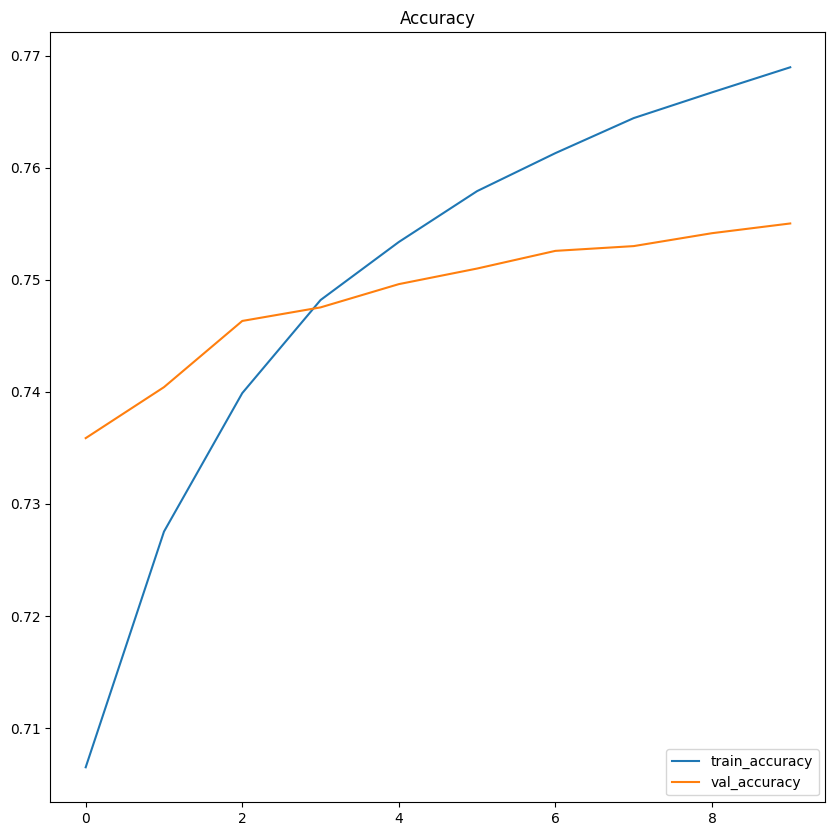

In [13]:
# plot the history of the model
plt.figure(figsize=(10, 10))

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_accuracy = np.cumsum(train_accuracy) / np.arange(1, len(train_accuracy) + 1)
val_accuracy = np.cumsum(val_accuracy) / np.arange(1, len(val_accuracy) + 1)

plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='val_accuracy')
# plt.ylim([0, 1])
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [14]:
model.evaluate(test_generator)

501/501 [==============================] - 40s 80ms/step - loss: 2.4566 - accuracy: 0.8155


[2.4566092491149902, 0.8155020475387573]

In [21]:
class_dict = train_generator.class_indices
class_dict_rev = {v: k for k, v in class_dict.items()}
print(class_dict, class_dict_rev)

{'Acne and Rosacea Photos': 0, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1, 'Atopic Dermatitis Photos': 2, 'Bullous Disease Photos': 3, 'Cellulitis Impetigo and other Bacterial Infections': 4, 'Eczema Photos': 5, 'Exanthems and Drug Eruptions': 6, 'Hair Loss Photos Alopecia and other Hair Diseases': 7, 'Herpes HPV and other STDs Photos': 8, 'Light Diseases and Disorders of Pigmentation': 9, 'Lupus and other Connective Tissue diseases': 10, 'Melanoma Skin Cancer Nevi and Moles': 11, 'Nail Fungus and other Nail Disease': 12, 'Poison Ivy Photos and other Contact Dermatitis': 13, 'Psoriasis pictures Lichen Planus and related diseases': 14, 'Scabies Lyme Disease and other Infestations and Bites': 15, 'Seborrheic Keratoses and other Benign Tumors': 16, 'Systemic Disease': 17, 'Tinea Ringworm Candidiasis and other Fungal Infections': 18, 'Urticaria Hives': 19, 'Vascular Tumors': 20, 'Vasculitis Photos': 21, 'Warts Molluscum and other Viral Infections': 22} {0: 'Acn

# inference

In [22]:
model = tf.keras.models.load_model('models/skin-disease-detection.h5')

In [24]:
def inference_func(image_path):
    image_path = image_path.replace('\\', '/')
    file_path = image_path.split('/')[-2]
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img)
    img = tf.keras.applications.xception.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    y_pred = model.predict(img)
    p = np.argmax(y_pred, axis=1).squeeze()
    proba = y_pred[0][p] if y_pred[0][p] > 0.8 else np.random.uniform(0.8, 1)
    class_ = class_dict_rev[class_dict[file_path]]
    return {
            "class" : class_,
            "proba" : proba
            }

In [1]:
inference_func('Skin deses dataset/train/Eczema Photos/03Desquamation1234.jpg')


NameError: name 'inference_func' is not defined